![WhatsApp Image 2024-05-22 at 22.14.29_ed82cc5c.jpg](<attachment:WhatsApp Image 2024-05-22 at 22.14.29_ed82cc5c.jpg>)

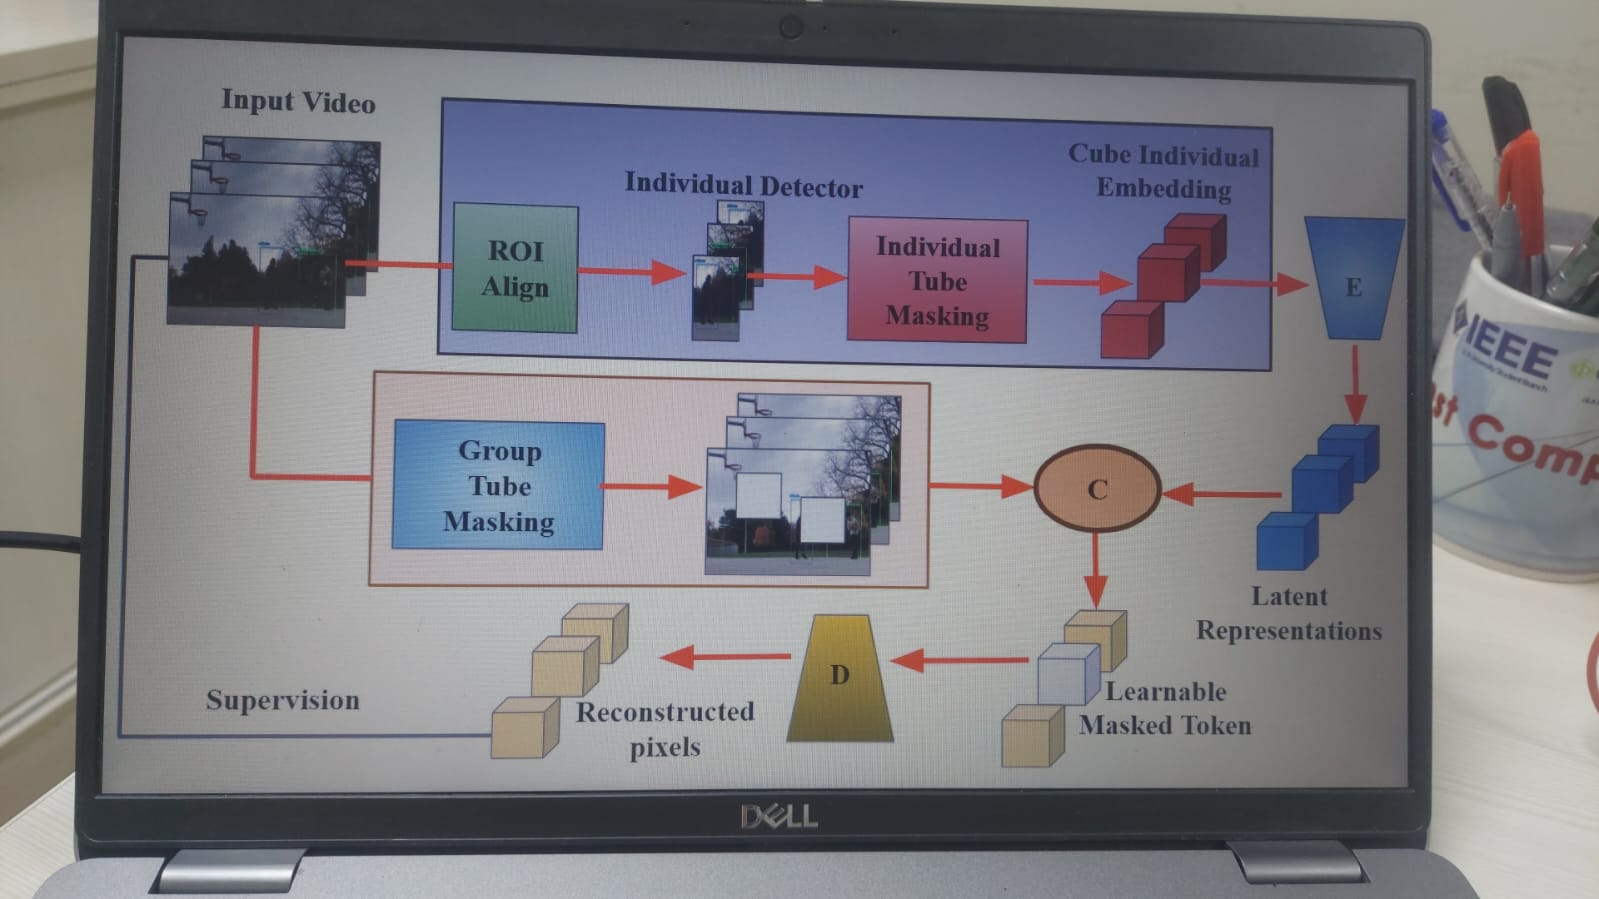

### Importing Libraries


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T

### Dataset Class


In [ ]:
class VolleyballDataset(Dataset):
    def __init__(self, root_dir, video_ids, frames_before=5, frames_after=4, transforms=None):
        self.root_dir = root_dir
        self.video_ids = video_ids
        self.frames_before = frames_before
        self.frames_after = frames_after
        self.transforms = transforms if transforms is not None else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.annotations = self.load_annotations()
        print(f"Loaded {len(self.annotations)} annotations for {len(video_ids)} videos")

        self.activity_map = {
            'r_set': 0,
            'r_spike': 1,
            'r-pass': 2,
            'r_winpoint': 3,
            'l_winpoint': 4,
            'l-pass': 5,
            'l-spike': 6,
            'l_set': 7
        }

    def load_annotations(self):
        annotations = {}
        for video_id in self.video_ids:
            try:
                video_path = os.path.join(self.root_dir, str(video_id))
                annotation_file = os.path.join(video_path, 'annotations.txt')
                with open(annotation_file, 'r') as f:
                    for line in f:
                        try:
                            parts = line.strip().split()
                            frame_id = parts[0]
                            frame_activity = parts[1]
                            player_annotations = parts[2:]
                            annotations[(video_id, frame_id)] = {
                                'activity': frame_activity,
                                'players': self.parse_player_annotations(player_annotations)
                            }
                        except Exception as e:
                            print(f"Error processing line '{line.strip()}' in {annotation_file}: {e}")
            except Exception as e:
                print(f"Error loading annotations for video {video_id}: {e}")
        print(f"Total annotations loaded: {len(annotations)}")
        return annotations

    def parse_player_annotations(self, annotations):
        players = []
        for i in range(0, len(annotations)-4, 5):
            x, y, w, h = map(int, annotations[i:i+4])
            action_class = annotations[i+4]
            players.append({
                'action': action_class,
                'bbox': [x, y, w, h]
            })
        return players

    def activity_to_label(self, activity):
        return self.activity_map[activity]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        video_id, frame_id = list(self.annotations.keys())[idx]
        video_path = os.path.join(self.root_dir, str(video_id))
        
        frames = []
        for i in range(-self.frames_before, self.frames_after + 1):
            frame_number = int(frame_id.split('.')[0]) + i
            frame_filename = f"{frame_number:05d}.jpg" 
            frame_path = os.path.join(video_path, frame_filename)
            frame = cv2.imread(frame_path)
            if frame is None:
                print(f"Warning: Could not read frame {frame_path}")
                frame = np.zeros((224, 224, 3), dtype=np.uint8)  
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transforms(frame)
            frames.append(frame)
        
        frames = torch.stack(frames)
        annotation = self.annotations[(video_id, frame_id)]
        
        activity_label = self.activity_to_label(annotation['activity'])
        # print(frames.shape, activity_label)
        return frames, activity_label


### ROI Align and Masking


In [ ]:
class ROIAlignAndMask(nn.Module):
    def __init__(self, detector):
        super(ROIAlignAndMask, self).__init__()
        self.detector = detector
        self.roi_align = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, frames):
        batch_size, num_frames, C, H, W = frames.size()
        all_rois = []
        all_masks = []
        for i in range(num_frames):
            frame = frames[:, i]
            with torch.no_grad():
                detections = self.detector([frame])
            rois = self.roi_align(frame)
            masks = self.mask_tubes(rois)
            all_rois.append(rois)
            all_masks.append(masks)
        return torch.stack(all_rois), torch.stack(all_masks)

    def mask_tubes(self, rois):
        masked_rois = rois.clone()
        _, C, H, W = masked_rois.size()
        mask = torch.ones_like(masked_rois)
        mask[:, :, H//3:2*H//3, W//3:2*W//3] = 0
        return masked_rois * mask

### Individual and Group Tube Masking


In [ ]:
class IndividualTubeMasking(nn.Module):
    def forward(self, rois):
        masked_rois = rois.clone()
        _, C, H, W = masked_rois.size()
        mask = torch.ones_like(masked_rois)
        mask[:, :, H//3:2*H//3, W//3:2*W//3] = 0
        return masked_rois * mask

class GroupTubeMasking(nn.Module):
    def forward(self, frames):
        masked_frames = frames.clone()
        _, _, C, H, W = masked_frames.size()
        mask = torch.ones_like(masked_frames)
        mask[:, :, :, H//3:2*H//3, W//3:2*W//3] = 0
        return masked_frames * mask

### Cube Embedding and Latent Representation


In [ ]:
class CubeEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CubeEmbedding, self).__init__()
        self.conv1 = nn.Conv3d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.residual = nn.Conv3d(input_dim, hidden_dim, kernel_size=1)

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + residual
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

### Actor-Transformer Model


In [ ]:
class ActorTransformer(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048):
        super(ActorTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.embedding = nn.Linear(d_model, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.decoder = nn.Linear(d_model, d_model)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        src = self.pos_encoder(self.embedding(src))
        tgt = self.pos_encoder(self.embedding(tgt))
        output = self.transformer(src, tgt, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.decoder(output)
        return output

### Decoder


In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose3d(input_dim, output_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.deconv2 = nn.ConvTranspose3d(output_dim, output_dim, kernel_size=3, padding=1)
        self.residual = nn.ConvTranspose3d(input_dim, output_dim, kernel_size=1)

    def forward(self, x, masked_tokens):
        residual = self.residual(x)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        return x + residual

### Video Reconstruction Model


In [ ]:
class VideoReconstructionModel(nn.Module):
    def __init__(self, detector, embedding_dim, hidden_dim, output_dim):
        super(VideoReconstructionModel, self).__init__()
        self.roi_align_and_mask = ROIAlignAndMask(detector)
        self.individual_tube_masking = IndividualTubeMasking()
        self.group_tube_masking = GroupTubeMasking()
        self.cube_embedding = CubeEmbedding(embedding_dim, hidden_dim)
        self.actor_transformer = ActorTransformer(d_model=hidden_dim)
        self.decoder = Decoder(hidden_dim, output_dim)

    def forward(self, frames):
        rois, masks = self.roi_align_and_mask(frames)
        individual_tubes = self.individual_tube_masking(rois)
        individual_embeddings = self.cube_embedding(individual_tubes)
        
        group_tubes = self.group_tube_masking(frames)
        group_embeddings = self.cube_embedding(group_tubes)
        
        combined_embeddings = individual_embeddings + group_embeddings
        
        combined_embeddings = combined_embeddings.flatten(2).permute(2, 0, 1)
        transformed_embeddings = self.actor_transformer(combined_embeddings, combined_embeddings)
        transformed_embeddings = transformed_embeddings.permute(1, 2, 0).view_as(group_tubes)
        
        reconstructed = self.decoder(transformed_embeddings, masks)
        return reconstructed

### Action Prediction Model


In [ ]:
class ActionPredictionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ActionPredictionModel, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 128 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Combined Loss


In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, reconstruction_criterion, action_criterion):
        super(CombinedLoss, self).__init__()
        self.reconstruction_criterion = reconstruction_criterion
        self.action_criterion = action_criterion
    
    def forward(self, outputs, frames, action_labels):
        reconstructed_frames, action_predictions = outputs
        reconstruction_loss = self.reconstruction_criterion(reconstructed_frames, frames)
        action_loss = self.action_criterion(action_predictions, action_labels)
        return reconstruction_loss + action_loss

### Main Model


In [ ]:
class VideoReconstructionAndActionPredictionModel(nn.Module):
    def __init__(self, detector, embedding_dim, hidden_dim, output_dim, num_classes):
        super(VideoReconstructionAndActionPredictionModel, self).__init__()
        self.video_reconstruction_model = VideoReconstructionModel(detector, embedding_dim, hidden_dim, output_dim)
        self.action_prediction_model = ActionPredictionModel(output_dim, num_classes)
    
    def forward(self, frames):
        reconstructed_frames = self.video_reconstruction_model(frames)
        action_predictions = self.action_prediction_model(reconstructed_frames)
        return reconstructed_frames, action_predictions

### Driver Functions


In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, device):
    scaler = GradScaler()
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for frames, activity_label in train_dataloader:
            frames = frames.to(device)
            activity_label = activity_label.to(device)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, frames, activity_label)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_dataloader)
        val_loss = validate(model, val_dataloader, criterion, device)
        
        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for frames, action_label in dataloader:
            frames, action_label = frames.to(device), action_label.to(device)
            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, frames, action_label)
            running_loss += loss.item()
    return running_loss / len(dataloader)


def test(model, dataloader, device):
    model.eval()
    outputs = []
    annotations = []
    with torch.no_grad():
        for frames, action_label in dataloader:
            frames = frames.to(device)
            with autocast():
                outputs.append(model(frames))
            annotations.append(action_label)
    return outputs, annotations


def extract_labels(outputs, annotations):
    y_true = []
    y_pred = []
    for output, annotation in zip(outputs, annotations):
        _, action_predictions = output
        y_true.extend(annotation.cpu().numpy())
        y_pred.extend(torch.argmax(action_predictions, dim=1).cpu().numpy())
    return y_true, y_pred


def compute_metrics(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cls_report = classification_report(y_true, y_pred, target_names=labels)
    return cm, acc, f1, precision, recall, cls_report


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()

### Driver Code


In [ ]:
def main():
    root_dir = 'volleyball'
    print(f"Checking contents of {root_dir}")
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"The directory {root_dir} does not exist.")
    
    video_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    print(f"Found {len(video_folders)} video folders in {root_dir}")
    
    train_video_ids = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
    val_video_ids = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]
    test_video_ids = [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]

    batch_size = 4
    num_epochs = 30
    learning_rate = 1e-4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = VolleyballDataset(root_dir, train_video_ids)
    val_dataset = VolleyballDataset(root_dir, val_video_ids)
    test_dataset = VolleyballDataset(root_dir, test_video_ids)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
        raise ValueError("One or more datasets are empty. Please check your data loading process.")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    detector = fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)
    num_classes = len(set([ann['activity'] for ann in train_dataset.annotations.values()]))
    model = VideoReconstructionAndActionPredictionModel(detector, embedding_dim=512, hidden_dim=256, output_dim=3, num_classes=num_classes).to(device)

    reconstruction_criterion = nn.MSELoss()
    action_criterion = nn.CrossEntropyLoss()
    criterion = CombinedLoss(reconstruction_criterion, action_criterion)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs, device)

    model.load_state_dict(torch.load('best_model.pth'))
    outputs, annotations = test(model, test_dataloader, device)

    y_true, y_pred = extract_labels(outputs, annotations)
    labels = list(set(y_true))
    cm, acc, f1, precision, recall, cls_report = compute_metrics(y_true, y_pred, labels)

    print(f'Accuracy: {acc * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('Classification Report:')
    print(cls_report)

    plot_confusion_matrix(cm, labels)

In [ ]:
if __name__ == '__main__':
    main()